# Description

This analysis takes inspiration from the paper [Unbiased determination of DVCS Compton Form Factors](https://arxiv.org/abs/1905.02089).


# Imports

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.2.0


In [3]:
class DvcsData(object):
    def __init__(self, df):
        self.X = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'ReH', 'ReE', 'ReHtilde', 'dvcs']]
        self.XnoCFF = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]
        self.y = df.loc[:, 'F']
        self.Kinematics = df.loc[:, ['k', 'QQ', 'x_b', 't']]
        self.erry = df.loc[:, 'errF']
        
    def __len__(self):
        return len(self.X)
    
    def getSet(self, setNum, itemsInSet=36):
        pd.options.mode.chained_assignment = None
        subX = self.X.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1, :]
        subX['F'] = self.y.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        subX['errF'] = self.erry.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        pd.options.mode.chained_assignment = 'warn'
        return DvcsData(subX)
    
    def sampleY(self):
        return np.random.normal(self.y, self.erry)
    
    def sampleWeights(self):
        return 1/self.erry
    
    def getAllKins(self, itemsInSets=36):
        return self.Kinematics.iloc[np.array(range(len(df)//itemsInSets))*itemsInSets, :]

In [4]:
df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
fits = pd.read_csv("fits.csv")
data = DvcsData(df)

In [5]:
valid_y = fits.sample(2)
train_y = fits.drop(valid_y.index)
valid_x = data.getAllKins().iloc[valid_y.index, :]
train_x = data.getAllKins().drop(valid_x.index)

In [6]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(10, activation="tanh")(kinematics)
outputs = tf.keras.layers.Dense(3)(x)

globalModel = tf.keras.Model(inputs=kinematics, outputs=outputs, name="GlobalModel")

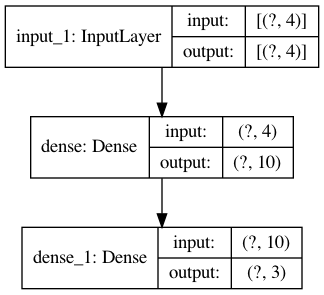

In [7]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

In [8]:
globalModel.compile(optimizer=tf.keras.optimizers.Adam(1), loss=tf.keras.losses.MeanSquaredError())

In [95]:
globalModel(valid_x)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 5.1054120e-01, -1.9755960e-04, -5.1804924e-01],
       [ 5.1641965e-01,  2.5556028e-02, -4.8931825e-01]], dtype=float32)>

In [62]:
valid_x.iloc[0, :]

k      6.750000
QQ     1.950720
x_b    0.360829
t     -0.278690
Name: 324, dtype: float64

In [63]:
valid_x.iloc[1, :]

k      4.750000
QQ     2.179550
x_b    0.385579
t     -0.283318
Name: 72, dtype: float64

In [64]:
globalModel(valid_x.iloc[[1], :])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[  9.75326  , -48.57067  ,   5.6907144]], dtype=float32)>

In [65]:
globalModel(valid_x.iloc[[0], :])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[  9.75326  , -48.57067  ,   5.6907144]], dtype=float32)>

In [66]:
globalModel(train_x)

<tf.Tensor: shape=(13, 3), dtype=float32, numpy=
array([[  9.753261, -48.570675,   5.690714],
       [  9.753261, -48.570675,   5.690714],
       [  9.753261, -48.570675,   5.690714],
       [  9.753261, -48.570675,   5.690714],
       [  9.753261, -48.570675,   5.690714],
       [  9.753261, -48.570675,   5.690714],
       [  9.753261, -48.570675,   5.690714],
       [  9.753261, -48.570675,   5.690714],
       [  9.753261, -48.570675,   5.690714],
       [  9.753261, -48.570675,   5.690714],
       [  9.753261, -48.570675,   5.690714],
       [  9.753261, -48.570675,   5.690714],
       [  9.753261, -48.570675,   5.690714]], dtype=float32)>

In [69]:
train_y.mean()

ReH          9.753328
ReE        -48.570673
ReHtilde     5.690670
dtype: float64

## ReHModel w Noise

In [27]:
fits

,ReH,ReE,ReHTilde,ReHerr,ReEerr,ReHTilderr
0,13.878755,-57.383343,6.799729,1.116576,5.740966,0.630739
1,11.719817,-47.746209,7.488039,2.559194,13.450243,1.250604
2,6.540862,-43.195876,4.484700,2.028538,11.627438,0.742568
3,8.982135,-54.485782,4.516039,2.945940,14.852145,1.118831
4,11.693827,-47.947156,7.354355,1.211438,6.219190,0.676689
5,6.719193,-44.275317,4.268059,1.419693,8.062980,0.486565
6,10.171167,-42.854521,6.951665,3.233800,18.385221,1.550622
7,8.872783,-53.917385,4.881407,2.489644,12.542550,1.702062
8,11.758800,-48.342613,7.245830,0.742077,3.826029,0.775337
9,8.099759,-53.588436,3.157422,0.978644,6.026498,0.439592


In [39]:
valid_y = fits["ReH"].sample(5)
valid_x = data.getAllKins().reset_index().loc[valid_y.index].drop(["index"], axis='columns')

In [40]:
train_x = data.getAllKins().reset_index().drop(["index"], axis='columns').drop(valid_x.index, axis='rows')
train_x = pd.DataFrame(np.repeat(train_x.values, 20, axis=0))

train_y = np.array([])
for row in range(15):
    if not row in valid_x.index:
        train_y = np.concatenate((train_y, np.random.normal(fits.loc[row, "ReH"], fits.loc[row, "ReHerr"], 20)))

In [132]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(1, activation='relu')(kinematics)
outputs = tf.keras.layers.Dense(1)(x)

ReHModel = tf.keras.Model(inputs=kinematics, outputs=outputs, name="GlobalModel")

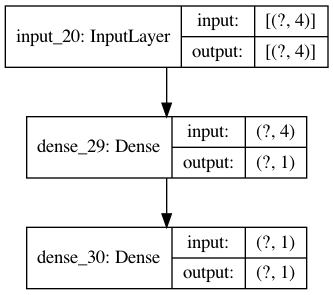

In [133]:
tf.keras.utils.plot_model(ReHModel, "cffs.png", show_shapes=True)

In [134]:
ReHModel.compile(optimizer=tf.keras.optimizers.Adam(.1), loss=tf.keras.losses.MeanSquaredError())

In [135]:
train_x

,0,1,2,3
0,3.75,1.74013,0.435095,-0.380868
1,3.75,1.74013,0.435095,-0.380868
2,3.75,1.74013,0.435095,-0.380868
3,3.75,1.74013,0.435095,-0.380868
4,3.75,1.74013,0.435095,-0.380868
...,...,...,...,...
195,7.75,1.95072,0.360829,-0.278690
196,7.75,1.95072,0.360829,-0.278690
197,7.75,1.95072,0.360829,-0.278690
198,7.75,1.95072,0.360829,-0.278690


In [136]:
#ReHModel.fit(train_x.drop([0, 2], axis='columns'), train_y, epochs=200)
ReHModel.fit(train_x, train_y, epochs=200)

Epoch 1/200
7/7 [==============================] - 0s 1ms/step - loss: 17.5640
Epoch 2/200
7/7 [==============================] - 0s 931us/step - loss: 17.2166
Epoch 3/200
7/7 [==============================] - 0s 1ms/step - loss: 14.4433
Epoch 4/200
7/7 [==============================] - 0s 2ms/step - loss: 13.3394
Epoch 5/200
7/7 [==============================] - 0s 1ms/step - loss: 11.8377
Epoch 6/200
7/7 [==============================] - 0s 1ms/step - loss: 10.8838
Epoch 7/200
7/7 [==============================] - 0s 1ms/step - loss: 10.7066
Epoch 8/200
7/7 [==============================] - 0s 2ms/step - loss: 9.6993
Epoch 9/200
7/7 [==============================] - 0s 1ms/step - loss: 9.2926
Epoch 10/200
7/7 [==============================] - 0s 904us/step - loss: 9.1958
Epoch 11/200
7/7 [==============================] - 0s 1ms/step - loss: 8.6889
Epoch 12/200
7/7 [==============================] - 0s 2ms/step - loss: 8.4059
Epoch 13/200
7/7 [==============================] 

7/7 [==============================] - 0s 1ms/step - loss: 5.2456
Epoch 104/200
7/7 [==============================] - 0s 896us/step - loss: 5.1124
Epoch 105/200
7/7 [==============================] - 0s 959us/step - loss: 5.3567
Epoch 106/200
7/7 [==============================] - 0s 829us/step - loss: 5.5698
Epoch 107/200
7/7 [==============================] - 0s 929us/step - loss: 4.9229
Epoch 108/200
7/7 [==============================] - 0s 830us/step - loss: 4.9867
Epoch 109/200
7/7 [==============================] - 0s 1ms/step - loss: 4.8957
Epoch 110/200
7/7 [==============================] - 0s 810us/step - loss: 4.9765
Epoch 111/200
7/7 [==============================] - 0s 972us/step - loss: 5.0369
Epoch 112/200
7/7 [==============================] - 0s 2ms/step - loss: 5.3723
Epoch 113/200
7/7 [==============================] - 0s 881us/step - loss: 5.4672
Epoch 114/200
7/7 [==============================] - 0s 1ms/step - loss: 5.8941
Epoch 115/200
7/7 [===================

In [137]:
ReHModel.weights

[<tf.Variable 'dense_29/kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[  0.07185411],
        [ -1.2169037 ],
        [  2.2498546 ],
        [-14.880165  ]], dtype=float32)>,
 <tf.Variable 'dense_29/bias:0' shape=(1,) dtype=float32, numpy=array([-0.29529765], dtype=float32)>,
 <tf.Variable 'dense_30/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.942429]], dtype=float32)>,
 <tf.Variable 'dense_30/bias:0' shape=(1,) dtype=float32, numpy=array([0.713438], dtype=float32)>]

In [138]:
valid_x

,k,QQ,x_b,t
13,7.75,2.17955,0.385579,-0.283318
14,7.75,2.63258,0.345012,-0.361188
8,5.75,2.03646,0.415563,-0.373495
5,5.75,2.17955,0.385579,-0.283318
7,5.75,2.07387,0.436939,-0.291599


In [139]:
valid_y

13     6.809949
14    10.773485
8     11.758800
5      6.719193
7      8.872783
Name: ReH, dtype: float64

In [140]:
#np.mean((ReHModel(valid_x.drop(["k", "x_b"], axis='columns')).numpy()[:, 0] - valid_y)**2)
np.mean((ReHModel(valid_x).numpy()[:, 0] - valid_y)**2)

1.4736239909344535

In [141]:
#ReHModel(valid_x.drop(["k", "x_b"], axis='columns'))
ReHModel(valid_x)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 8.636179],
       [10.154925],
       [12.872473],
       [ 8.213327],
       [ 9.294309]], dtype=float32)>

## With only QQ and t

In [152]:
kinematics = tf.keras.Input(shape=(2))
x = tf.keras.layers.Dense(1, activation='relu')(kinematics)
outputs = tf.keras.layers.Dense(1)(x)

ReHModel = tf.keras.Model(inputs=kinematics, outputs=outputs, name="GlobalModel")

In [153]:
ReHModel.compile(optimizer=tf.keras.optimizers.Adam(.1), loss=tf.keras.losses.MeanSquaredError())

In [154]:
ReHModel.fit(train_x.drop([0, 2], axis='columns'), train_y, epochs=200)

Epoch 1/200
7/7 [==============================] - 0s 1ms/step - loss: 103.6929
Epoch 2/200
7/7 [==============================] - 0s 940us/step - loss: 78.4671
Epoch 3/200
7/7 [==============================] - 0s 851us/step - loss: 46.6734
Epoch 4/200
7/7 [==============================] - 0s 1ms/step - loss: 15.4216
Epoch 5/200
7/7 [==============================] - 0s 1ms/step - loss: 17.6828
Epoch 6/200
7/7 [==============================] - 0s 1ms/step - loss: 11.7048
Epoch 7/200
7/7 [==============================] - 0s 1ms/step - loss: 12.2842
Epoch 8/200
7/7 [==============================] - 0s 995us/step - loss: 10.9237
Epoch 9/200
7/7 [==============================] - 0s 1ms/step - loss: 11.6488
Epoch 10/200
7/7 [==============================] - 0s 1ms/step - loss: 11.0772
Epoch 11/200
7/7 [==============================] - 0s 1ms/step - loss: 10.7525
Epoch 12/200
7/7 [==============================] - 0s 1ms/step - loss: 10.7067
Epoch 13/200
7/7 [========================

7/7 [==============================] - 0s 976us/step - loss: 4.8482
Epoch 104/200
7/7 [==============================] - 0s 904us/step - loss: 5.0918
Epoch 105/200
7/7 [==============================] - 0s 988us/step - loss: 5.1939
Epoch 106/200
7/7 [==============================] - 0s 943us/step - loss: 5.0829
Epoch 107/200
7/7 [==============================] - 0s 896us/step - loss: 4.8886
Epoch 108/200
7/7 [==============================] - 0s 845us/step - loss: 4.8725
Epoch 109/200
7/7 [==============================] - 0s 921us/step - loss: 4.9633
Epoch 110/200
7/7 [==============================] - 0s 843us/step - loss: 4.7566
Epoch 111/200
7/7 [==============================] - 0s 896us/step - loss: 4.7328
Epoch 112/200
7/7 [==============================] - 0s 930us/step - loss: 4.7236
Epoch 113/200
7/7 [==============================] - 0s 892us/step - loss: 4.8417
Epoch 114/200
7/7 [==============================] - 0s 926us/step - loss: 4.7853
Epoch 115/200
7/7 [===========

In [155]:
np.mean((ReHModel(valid_x.drop(["k", "x_b"], axis='columns')).numpy()[:, 0] - valid_y)**2)

0.7736099979173463

In [163]:
ReHModel(valid_x.drop(["k", "x_b"], axis='columns'))

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 7.250562],
       [ 9.148408],
       [11.995115],
       [ 7.250562],
       [ 8.039215]], dtype=float32)>

Mean absolute percent error

In [165]:
np.mean(np.abs((valid_y - ReHModel(valid_x.drop(["k", "x_b"], axis='columns')).numpy()[:,0])/valid_y))

0.08173352818435002

## All kinematics for all cffs

In [208]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(1, activation='relu')(kinematics)
outputs = tf.keras.layers.Dense(1)(kinematics)

cffModel = tf.keras.Model(inputs=kinematics, outputs=outputs, name="GlobalModel")

In [209]:
cffModel.compile(optimizer=tf.keras.optimizers.Adam(3), loss=tf.keras.losses.MeanSquaredError())

In [210]:
reh = tf.keras.models.clone_model(cffModel)
ree = tf.keras.models.clone_model(cffModel)
reht = tf.keras.models.clone_model(cffModel)
cffModels = [reh, ree, reht]

In [211]:
names = ["ReH", "ReE", "ReHTilde"]
for i in range(3):
    valid_y = fits[names[i]].sample(5)
    valid_x = data.getAllKins().reset_index().loc[valid_y.index].drop(["index"], axis='columns')

    train_x = data.getAllKins().reset_index().drop(["index"], axis='columns').drop(valid_x.index, axis='rows')
    train_x = pd.DataFrame(np.repeat(train_x.values, 20, axis=0))

    train_y = np.array([])
    for row in range(15):
        if not row in valid_x.index:
            train_y = np.concatenate((train_y, np.random.normal(fits.loc[row, names[i]],
                                                                fits.loc[row, names[i] + "err"], 20)))
    cffModels[i].compile(optimizer=tf.keras.optimizers.Adam(.1), loss=tf.keras.losses.MeanSquaredError())
    #cffModels[i].fit(train_x.drop([0, 2], axis='columns'), train_y, epochs=200, verbose=0)
    cffModels[i].fit(train_x, train_y, epochs=1000, verbose=0)
    
    print(names[i] + ":")
    #print(cffModels[i](valid_x.drop(["k", "x_b"], axis='columns')))
    print(cffModels[i](valid_x))
    print("Mean absolute pct error:")
    #print(np.mean(np.abs((valid_y - cffModels[i](valid_x.drop(["k", "x_b"], axis='columns')).numpy()[:,0])/valid_y)))
    print(np.mean(np.abs((valid_y - cffModels[i](valid_x).numpy()[:,0])/valid_y)))
    print("\n")

ReH:
tf.Tensor(
[[12.529621 ]
 [ 7.446174 ]
 [ 7.2702117]
 [10.864798 ]
 [ 7.4433093]], shape=(5, 1), dtype=float32)
Mean absolute pct error:
0.10784508043678073


ReE:
tf.Tensor(
[[-53.221107]
 [-48.02896 ]
 [-47.889496]
 [-45.116707]
 [-47.113403]], shape=(5, 1), dtype=float32)
Mean absolute pct error:
0.07766827303997292


ReHTilde:
tf.Tensor(
[[3.793664 ]
 [4.0030546]
 [4.2661314]
 [7.0023346]
 [7.211725 ]], shape=(5, 1), dtype=float32)
Mean absolute pct error:
0.07943223417405403


